In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl

In [80]:
def _shift_vertices(vertices, dists):
    """ shifts the vertices of a polygon inward uniformly by distances 
    `dists`.  Returns new polygon vertices, one for each dist.
    """

    # cast dists to array just to be safe (if float)
    dists = np.array(dists)

    if np.all(np.isclose(dists, 0)):
        return vertices

    def rot90(v):
        """ 90 degree rotation of 2d vector
            vx -> vy
            vy -> -vx
        """
        vxs, vys = v
        return np.stack((-vys, vxs), axis=0)
    
    def cross(v1, v2):
        return np.cross(v1, v2, axis=0)
    
    def normalize(v):
        return v / (np.linalg.norm(v, axis=0))
    
    num_verts = vertices.shape[0]
    
    vs = vertices.T.copy()
    vsp = np.roll(vs.copy(), axis=-1, shift=-1)
    vsm = np.roll(vs.copy(), axis=-1, shift=+1)
    
    asp = normalize(vsp - vs)
    asm = normalize(vs - vsm)

    vs_new = vs + dists[..., None, None] * rot90(asm)
    det = cross(asp, asm)

    det_nz = 1.0 - 1.0 * np.isclose(det, 0)

    tmp = (cross(asm, rot90(asm-asp)) / (det + 1e-9))
    corrections = (1 - np.isclose(det, 0)) * dists[..., None, None] * tmp

    return np.swapaxes(vs_new + corrections * asm, -2, -1)

class Polygon:
    def __init__(self, vertices, zbounds, side_angle=0.0):
        # note: vertices are 'base' vertices (at zmin or zbounds[0])
        self.vertices = np.array(vertices)
        self.zbounds = self.zmin, self.zmax = zbounds
        # note: side angle is in degrees with 0 meaning straight, >0 meaning smaller top
        self.side_angle = side_angle
        self.side_angle_rad = side_angle / 180 * np.pi
    
    def intersects(self, axis='z', pos=0.0):
        """ returns list of (N,2) polygon vertices in the plane normal to axis at position axis=pos """
        if axis == 'x':
            return self._intersects_x(pos)
        elif axis == 'y':
            return self._intersects_y(pos)
        elif axis == 'z':
            return self._intersects_z(pos)
    
    def _intersects_side(self, pos, axis='x'):
        """ finds intersection with polygon at position axis=pos, for axis=x or y """

        assert axis in ('x', 'y')

        # get all segments
        v1 = self.vertices
        
        # if axis is y, just flip x,y coordinates and do the same as for x
        if axis == 'y':
            v1 = np.roll(v1, shift=1, axis=1)

        # get 'next' segments
        v2 = np.roll(v1, shift=1, axis=0)

        # find which segments intersect
        intersects_forward = np.logical_and((v1[:,0] <= pos), (v2[:,0] > pos))
        intersects_backward = np.logical_and((v2[:,0] <= pos), (v1[:,0] > pos))
        intersects_segment = np.logical_or(intersects_forward, intersects_backward)
        ints_v1 = v1[intersects_segment]
        ints_v2 = v2[intersects_segment]

        # for each intersecting segment, find specific intersection point (in y) assuming straight line
        ints_y = []
        for (_v1, _v2) in zip(ints_v1, ints_v2):
            # find the interescting y
            x1, y1 = _v1
            x2, y2 = _v2
            slope = (y2 - y1) / (x2 - x1)
            y = y1 + slope * (pos - x1)
            ints_y.append(y)

        # sort the intersections just to be safe
        ints_y.sort()
                   
        # make polygon with intersections and z axis information
        polys = []
        for i in range(len(ints_y) // 2):

            # consecutive smaller and larger y points, respectively, assumed material between them
            y1 = ints_y[2*i]
            y2 = ints_y[2*i + 1]
            
            # make the polygon
            if np.isclose(self.side_angle, 0.0):
                # normal case, just make a rectangle
                poly = [(y1, self.zmin), (y2, self.zmin), (y2, self.zmax), (y1, self.zmax)]
            else:
                # sidewall angle case, get distances needed for calculation
                dist_y = np.abs(y2 - y1)
                dist_z = np.abs(self.zmax - self.zmin)
                
                # distance in z where the sidewalls would intersect
                hz = np.abs(dist_y / 2 / np.tan(self.side_angle_rad))
                if hz < dist_z and self.side_angle > 0:
                    # if they do intersect before reaching top of polygon (and it's positive side wall) make triangle
                    y_mid = (y1 + y2) / 2
                    poly = [(y1, self.zmin), (y2, self.zmin), (y_mid, self.zmin + hz)]
                else:
                    # otherwise, just adjust the y positions of the top part of the polygon to shift based on sidewall
                    dy = dist_z * np.tan(self.side_angle_rad)
                    poly = [(y1, self.zmin), (y2, self.zmin), (y2-dy, self.zmax), (y1+dy, self.zmax)]        

            polys.append(poly)
        return polys
    
    def _intersects_x(self, pos):
        return self._intersects_side(pos, axis='x')

    def _intersects_y(self, pos):
        return self._intersects_side(pos, axis='y')
    
    def _intersects_z(self, pos):
        if (self.zmin > pos) or (self.zmax < pos):
            # if outside of z bounds, return nothing
            return []
        elif np.isclose(self.side_angle, 0.0):
            # if inside bounds and no side angle, return orginal vertices
            return [self.vertices]
        else:
            # if side angle present, compute shifting of polygon as function of pos and return shifted
            dist_z = pos - self.zmin
            dist_shift = dist_z * np.tan(self.side_angle_rad)
            vertices_shifted = _shift_vertices(self.vertices, dist_shift)
            return [vertices_shifted]

In [81]:
# constructs star polygon

# inner and outer radii of star
r_in = 0.4
r_out = 1.0

# inner and outer star vertices
inner_vertices = [(r_in * np.cos(2*np.pi*i/5 + np.pi/2 - np.pi/5), r_in * np.sin(2*np.pi*i/5 + np.pi/2 - np.pi/5)) for i in range(5)]
outer_vertices = [(r_out * np.cos(2*np.pi*i/5 + np.pi/2), r_out * np.sin(2*np.pi*i/5 + np.pi/2)) for i in range(5)]

# interweave inner and outer vertices to make star
star_vertices = []
for i in range(5):
    star_vertices.append(inner_vertices[i])
    star_vertices.append(outer_vertices[i])

In [67]:
def plot_polygons(vertices_list, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1)
    for vertices in vertices_list:
        patch = mpl.patches.Polygon(vertices)
        ax.add_patch(patch)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    return ax

In [76]:
p = Polygon(star_vertices, zbounds=(-1, 1), side_angle=5)

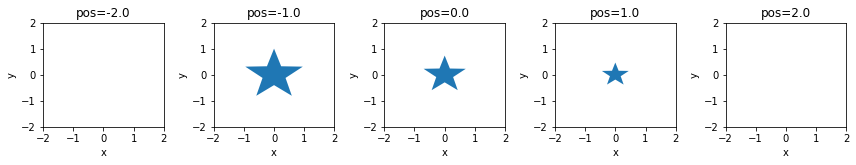

In [77]:
# z direction
pos_list = np.linspace(-2, 2, 5)

n_pos = len(pos_list)
f, axes = plt.subplots(1, n_pos, tight_layout=True, figsize=(12, 12/n_pos))
for ax, pos in zip(axes, pos_list):
    polygons = p.intersects(axis='z', pos=pos)
    ax = plot_polygons(polygons, ax=ax)
    ax.set_title(f'pos={pos:.1f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')    
plt.show()

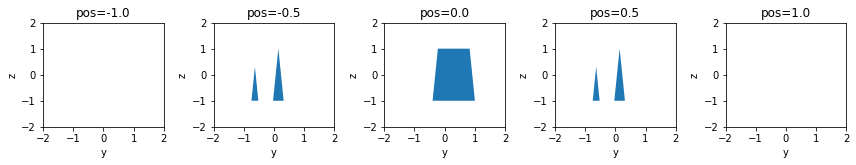

In [78]:
# x direction
pos_list = np.linspace(-1, 1, 5)

n_pos = len(pos_list)
f, axes = plt.subplots(1, n_pos, tight_layout=True, figsize=(12, 12/n_pos))

for ax, pos in zip(axes, pos_list):
    polygons = p.intersects(axis='x', pos=pos)
    ax = plot_polygons(polygons, ax=ax)
    ax.set_title(f'pos={pos:.1f}')
    ax.set_xlabel('y')
    ax.set_ylabel('z')
plt.show()

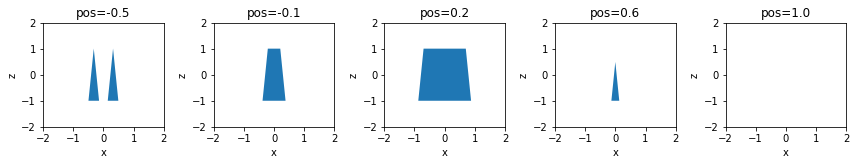

In [79]:
# x direction
pos_list = np.linspace(-0.5, 1, 5)

n_pos = len(pos_list)
f, axes = plt.subplots(1, n_pos, tight_layout=True, figsize=(12, 12/n_pos))

for ax, pos in zip(axes, pos_list):
    polygons = p.intersects(axis='y', pos=pos)
    ax = plot_polygons(polygons, ax=ax)
    ax.set_title(f'pos={pos:.1f}')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
plt.show()